In [1]:
import sys
import os
import uuid
from dotenv import load_dotenv

# 1. Load Env & Paths
load_dotenv("../.env")
sys.path.append("..")

# 2. Import the NEW Agent
from src.agents.graph import app
from langchain_core.messages import HumanMessage

print("✅ Agent imported successfully")

✅ Agent imported successfully


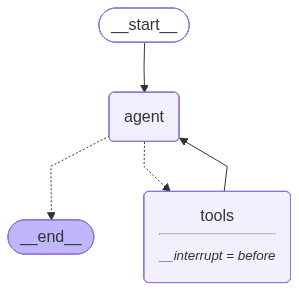

In [3]:
from IPython.display import Image, display

try:
    # This should now show a simpler graph: "agent" <--> "tools"
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization skipped (requires graphviz).")

In [4]:
# 3. Helper Function to Run Agent with Auto-Approval
from langchain_core.messages import ToolMessage

def run_agent_until_complete(initial_input, thread_id):
    """
    Runs the agent and automatically approves tool calls (interrupts).
    """
    print(f"🚀 Starting Thread: {thread_id}\n")
    
    # Setup Config
    config = {"configurable": {"thread_id": thread_id}}
    
    # Send Initial Message
    print(f"👤 USER: {initial_input}")
    current_input = {"messages": [HumanMessage(content=initial_input)]}
    
    # Loop until the agent stops naturally
    while True:
        # Run the stream
        # 'values' mode returns the FULL history at every step
        for event in app.stream(current_input, config=config, stream_mode="values"):
            message = event["messages"][-1]
            
            # Print AI reasoning or Tool Calls
            if message.type == "ai":
                if message.tool_calls:
                    print(f"\n🤖 AGENT WANTS TO USE TOOL: {message.tool_calls[0]['name']}")
                    print(f"   Args: {message.tool_calls[0]['args']}")
                elif message.content:
                    print(f"\n🤖 AGENT THOUGHT: {message.content}")
            
            # Print Tool Outputs
            elif message.type == "tool":
                # Truncate long results for cleaner output
                content_preview = str(message.content)[:200] + "..." if len(str(message.content)) > 200 else str(message.content)
                print(f"\n🛠️ TOOL RESULT: {content_preview}")

        # Check for Pause (Interrupt)
        snapshot = app.get_state(config)
        
        if snapshot.next:
            # If 'next' is not empty, the agent is paused waiting for tool execution
            print("\n⏸️  PAUSED: Agent is waiting for tool approval.")
            print("▶️  AUTO-RESUMING (Simulating Human Approval)...")
            
            # Resume by passing None (this tells LangGraph "Go ahead")
            current_input = None 
        else:
            # If 'next' is empty, the agent is finished!
            print("\n✅ WORKFLOW FINISHED.")
            break

In [8]:
# 4. Test Case 1: High Risk Guest (John Doe)
# Expected: Scout -> Risk (High) -> Policy (High Risk Rules) -> Email (Offer Discount)

thread_id = f"test_run_{uuid.uuid4().hex[:5]}"

run_agent_until_complete(
    initial_input="Process retention for customer John Doe (ID: 101).", 
    thread_id=thread_id
)

🚀 Starting Thread: test_run_8059f

👤 USER: Process retention for customer John Doe (ID: 101).

🤖 AGENT WANTS TO USE TOOL: fetch_customer_booking
   Args: {'customer_id': 101}

⏸️  PAUSED: Agent is waiting for tool approval.
▶️  AUTO-RESUMING (Simulating Human Approval)...

🤖 AGENT WANTS TO USE TOOL: fetch_customer_booking
   Args: {'customer_id': 101}

✋ REQUESTING APPROVAL: High-value customer
Proposed Offer: 20% discount

✋ REQUESTING APPROVAL: High-value customer
Proposed Offer: Presidential upgrade

📧 SENDING EMAIL TO: John Doe (johndoe@example.com)
📝 SUBJECT: Retention Offer
----------------------------------------
Dear John, we value your loyalty and would like to offer you a 20% discount on your next stay. Please let us know if you are interested. Best regards, [Your Name]



TypeError: 'StructuredTool' object is not callable

In [6]:
# 5. Test Case 2: Low Risk Guest (Jane Smith)
# Expected: Scout -> Risk (Low) -> Policy (Low Risk Rules) -> Email (Friendly, no discount)

thread_id_2 = f"test_run_{uuid.uuid4().hex[:5]}"

run_agent_until_complete(
    initial_input="Process retention for customer Jane Smith (ID: 202).", 
    thread_id=thread_id_2
)

🚀 Starting Thread: test_run_fb1c8

👤 USER: Process retention for customer Jane Smith (ID: 202).

🤖 AGENT WANTS TO USE TOOL: fetch_customer_booking
   Args: {'customer_id': 202}

⏸️  PAUSED: Agent is waiting for tool approval.
▶️  AUTO-RESUMING (Simulating Human Approval)...

🤖 AGENT WANTS TO USE TOOL: fetch_customer_booking
   Args: {'customer_id': 202}

✋ REQUESTING APPROVAL: High-value customer
Proposed Offer: 20% discount

✋ REQUESTING APPROVAL: High-value customer
Proposed Offer: Presidential upgrade

📧 SENDING EMAIL TO: Jane Smith (jane.smith@example.com)
📝 SUBJECT: Retention Offer
----------------------------------------
Dear Jane, we value your loyalty and would like to offer you a 10% discount on your next stay. Please let us know if you are interested.



TypeError: 'StructuredTool' object is not callable